<a href="https://colab.research.google.com/github/fzanart/GHDomains/blob/main/Sentence_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
%%capture
!pip install -U sentence-transformers
!pip install flaml

In [32]:
from sentence_transformers import SentenceTransformer
from flaml import AutoML
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import classification_report, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import chi2, SelectKBest, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import matplotlib.pyplot as plt
import markdown
import lxml
from bs4 import BeautifulSoup
import re
import time
import unicodedata
import spacy
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [33]:
df = pd.read_csv('/content/drive/MyDrive/GHDomains/expanded_frame_final.csv')
df.dropna(subset=['Readme'], inplace=True)
df.drop(31, axis=0, inplace=True)   #removed repo Homebrew/legacy-homebrew      # Software tools
df.drop(124, axis=0, inplace=True)  #removed repo shadowsocks/shadowsocks       # Software tools
df.drop(237, axis=0, inplace=True)  #removed repo npm/npm                       # Software tools
df.drop(3057, axis=0, inplace=True) #removed repo firstopinion/formatter.js     # Web libraries and frameworks
df.drop(4488, axis=0, inplace=True) #removed repo jersey/jersey                 # Web libraries and frameworks
df.reset_index(inplace=True, drop=True)

df['Domain'] = df['Domain'].replace(['System software','Application software'], 'Application & System software')
df

,Stars,Forks,Language dict,Description,Url,Readme,Topics,Languages,Licence,Labels,...,Contents,Description Length,Readme Length,Contributor Count,Topic Count,Content Count,Name,Domain,Main Language,Sum of bytes
0,323943.0,25410.0,"[{'JavaScript': 1492576, 'CSS': 103413, 'Shell...",freeCodeCamp.org's open source codebase and cu...,https://api.github.com/repos/freeCodeCamp/free...,![freeCodeCamp.org Social Banner](https://s3.a...,"['learn-to-code', 'nonprofits', 'programming',...","['JavaScript', 'CSS', 'Shell', 'HTML', 'EJS', ...","BSD 3-Clause ""New"" or ""Revised"" License","['crowdin-sync', 'first timers only', 'help wa...",...,"['.dockerignore', '.editorconfig', '.eslintign...",79.0,18148.0,410.0,15.0,40.0,freeCodeCamp/freeCodeCamp,Documentation,JavaScript,1606036
1,150012.0,71296.0,"[{'JavaScript': 738421, 'HTML': 575762, 'SCSS'...","The most popular HTML, CSS, and JavaScript fra...",https://api.github.com/repos/twbs/bootstrap,"<p align=""center"">\n <a href=""https://getboot...","['css', 'bootstrap', 'javascript', 'html', 'sc...","['JavaScript', 'HTML', 'SCSS', 'CSS', 'PowerSh...",MIT License,"['3rd-party', 'CI', 'accessibility', 'awaiting...",...,"['.babelrc.js', '.browserslistrc', '.bundlewat...",113.0,13218.0,375.0,7.0,26.0,twbs/bootstrap,Web libraries and frameworks,JavaScript,1800587
2,96800.0,22341.0,[{'JavaScript': 2361}],"Bring data to life with SVG, Canvas and HTML. ...",https://api.github.com/repos/d3/d3,"# D3: Data-Driven Documents\n\n<a href=""https:...",['visualization'],['JavaScript'],"BSD 3-Clause ""New"" or ""Revised"" License","['bug', 'code', 'docs', 'droid', 'ios', 'linux...",...,"['.gitignore', 'API.md', 'CHANGES.md', 'ISSUE_...",89.0,2305.0,122.0,1.0,13.0,d3/d3,Web libraries and frameworks,JavaScript,2361
3,168294.0,33061.0,"[{'JavaScript': 5539058, 'HTML': 115651, 'CSS'...","A declarative, efficient, and flexible JavaScr...",https://api.github.com/repos/facebook/react,# [React](https://reactjs.org/) &middot; [![Gi...,"['javascript', 'react', 'frontend', 'declarati...","['JavaScript', 'HTML', 'CSS', 'C++', 'TypeScri...",MIT License,"['Browser: IE', 'Browser: Safari', 'CLA Signed...",...,"['.circleci', '.codesandbox', '.editorconfig',...",87.0,5166.0,431.0,6.0,29.0,facebook/react,Web libraries and frameworks,JavaScript,5815290
4,59608.0,28135.0,"[{'JavaScript': 6810485, 'HTML': 84393, 'Shell...",AngularJS - HTML enhanced for web apps!,https://api.github.com/repos/angular/angular.js,AngularJS [![CircleCI](https://circleci.com/gh...,NaN,"['JavaScript', 'HTML', 'Shell', 'PHP', 'CSS']",MIT License,"['In Progress', 'Intent-To-Deprecate', 'Known ...",...,"['.circleci', '.editorconfig', '.eslintignore'...",39.0,5965.0,406.0,NaN,51.0,angular/angular.js,Web libraries and frameworks,JavaScript,6937316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,1850.0,349.0,[{'Java': 32480}],This project aims to provide a working page fl...,https://api.github.com/repos/Yalantis/FlipView...,# Changes:\n\n * Made clickable views like a ...,"['android', 'java', 'viewpager', 'animation', ...",['Java'],NaN,"['bug', 'duplicate', 'enhancement', 'help want...",...,"['.gitignore', 'README.md', 'build.gradle', 'f...",86.0,4557.0,4.0,5.0,11.0,Yalantis/FlipViewPager.Draco,Non-web libraries and frameworks,Java,32480
4944,1780.0,178.0,"[{'JavaScript': 123266, 'CSS': 6537, 'HTML': 1...",JavaScript Client-Side Cookie Manipulation Lib...,https://api.github.com/repos/ScottHamper/Cookies,# Cookies.js\n\nCookies.js is a small client-s...,NaN,"['JavaScript', 'CSS', 'HTML']",The Unlicense,"['bug', 'duplicate', 'enhancement', 'invalid',...",...,"['.gitignore', 'CHANGELOG.md', 'README.md', 'U...",50.0,7338.0,11.0,NaN,7.0,ScottHamper/Cookies,Web libraries and frameworks,JavaScript,131183
4945,3138.0,300.0,"[{'C': 77760, 'Assembly': 15792}]",The earliest versions of the very first c comp...,https://api.github.com/repos/mortdeus/legacy-cc,legacy-cc\n=========\n\nThe earliest versions ...,NaN,"['C', 'Assembl

In [34]:
pd.isna(df['Topics']).sum(), pd.isna(df['Topics']).sum()/5000

(2613, 0.5226)

In [35]:
# Topics could be a great feature for the classifier. However, more than a half of the values are empty.
pd.concat([pd.isna(df['Topics']).groupby(by=df['Domain']).sum(),df['Domain'].value_counts(),df['Domain'].value_counts(normalize=True)], axis=1).rename({'Topics':'Missing Topics','Domain':'Total Values'},axis=1)


,Missing Topics,Total Values,Total Values
Application & System software,287,607,0.122676
Documentation,257,427,0.086297
Non-web libraries and frameworks,812,1429,0.288804
Software tools,453,963,0.194624
Web libraries and frameworks,804,1522,0.307599


In [36]:
def join_words_from_lists(text, join=False):
  text = str(text)
  if text == 'nan':
    return ''
  else:
    text = text[1:-1]
    text = text.replace('\'','')
    text = text.split(',')
    if join:
      text = ' '.join([word.strip() for word in text])
    return text

def normalise_text(text):

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')        # decode text to utf8 - remove non ascii charcters
    text = " ".join(token.norm_ if not token.lower else token.text for token in nlp(text) if not token.like_url and not token.like_email)  # regularise text remove urls and emails.
    text = re.sub('\s{2,}', " ", text)                                                              
    text = text.strip()                                                                                   

    return text


def clean_htmltags(text):

    html = markdown.markdown(text)                                # convert the code to html
    soup = BeautifulSoup(html, "lxml")                            # html.parser #XML stands for "eXtensible Markup Language",
    
    [s.extract() for s in soup(['iframe', 'script'])]             # eliminate html tags 
    stripped_text = soup.get_text()                               # get the rest of the text
    stripped_text = re.sub(r'[\r|\n|\r\n]+', ' ', stripped_text)  # delete remaining tags
    text = stripped_text                                          #
                                    
    return text

In [37]:
df['Labels'] = df['Labels'].apply(lambda x: join_words_from_lists(x, join=True))
df['Labels'] = df['Labels'].apply(lambda x: normalise_text(x))

In [38]:
df['Labels']

0       crowdin - sync first timers only help wanted i...
1       3rd - party CI accessibility awaiting - reply ...
2       bug code docs droid ios linux moz ms o perf pk...
3       Browser : IE Browser : Safari CLA Signed Compo...
4       In Progress Intent - To - Deprecate Known Issu...
                              ...                        
4943    bug duplicate enhancement help wanted invalid ...
4944    bug duplicate enhancement invalid needs - docu...
4945    bug duplicate enhancement invalid question won...
4946                                                     
4947    breaking change bug c++11 c++14 ci compositing...
Name: Labels, Length: 4948, dtype: object

In [39]:
df['Readme'] = df['Readme'].astype(str)
df['Readme'] = df['Readme'].apply(lambda x: clean_htmltags(x))
df['Readme'] = df['Readme'].apply(lambda x: normalise_text(x))

In [40]:
df['Readme']

0       's open - source codebase and curriculum is a ...
1       Bootstrap Sleek , intuitive , and powerful fro...
2       D3 : Data - Driven Documents D3 ( or D3.js ) i...
3       React React is a JavaScript library for buildi...
4       AngularJS AngularJS lets you write client - si...
                              ...                        
4943    Changes : Made clickable views like a button c...
4944    Cookies.js Cookies.js is a small client - side...
4945    legacy - cc The earliest versions of the very ...
4946    ELCImagePickerController A clone of the UIImag...
4947    _ / _ / _ / _ / _ /_/ _ /_/ _ /_/_/ _ /_/_/ _ ...
Name: Readme, Length: 4948, dtype: object

In [41]:
df['Description'] = df['Description'].astype(str)
df['Description'] = df['Description'].replace('nan','')
df['Description'] = df['Description'].apply(lambda x: normalise_text(x))
df['Text_data']   = df['Description'] + df['Readme'] + df['Labels']

In [42]:
df['Text_data']

0       's open source codebase and curriculum . Learn...
1       The most popular HTML , CSS , and JavaScript f...
2       Bring data to life with SVG , Canvas and HTML ...
3       A declarative , efficient , and flexible JavaS...
4       AngularJS - HTML enhanced for web apps !Angula...
                              ...                        
4943    This project aims to provide a working page fl...
4944    JavaScript Client - Side Cookie Manipulation L...
4945    The earliest versions of the very first c comp...
4946    A clone of the UIImagePickerController using t...
4947    Mapnik is an open source toolkit for developin...
Name: Text_data, Length: 4948, dtype: object

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!='Domain'], df['Domain'], test_size=0.1, random_state=42, stratify=df['Domain'])

In [44]:
Y_train = pd.get_dummies(y_train)

def vect_reduce_features(Y_train, train, test, prefix, Selectmodel=False, Select50Best=False, defaultVect=False):

    # Save indexes
    train_text_index = train.index
    test_text_index  = test.index

    # Vectorize the words contained into lists
    vect = CountVectorizer(tokenizer=join_words_from_lists)
    
    if defaultVect:
      print('using default vectoriser')
      vect = CountVectorizer()

    train = vect.fit_transform(train.astype(str))

    # Select features to reduce the dimensionality acording the selected method (FromModel or KBest)
    Y_train = pd.get_dummies(y_train)
    labels = Y_train.columns
    selected_features = []

    if Selectmodel:

        for label in labels:
            selector =  SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000))
            selector.fit(train, Y_train[label])
            features = selector.get_support()
            selected_features.extend(list(vect.get_feature_names_out()[features]))

    if Select50Best:

        for label in labels:
            selector =  SelectKBest(chi2, k=50) # SelectFpr(chi2, alpha=0.01)
            selector.fit(train, Y_train[label])
            features = selector.get_support()
            selected_features.extend(list(vect.get_feature_names_out()[features]))

    # Apply the selected features to the vectorised train matrix
    bolean_columns = np.isin(vect.get_feature_names_out(),list(set(selected_features)))
    column_indices = [j for i in np.argwhere(bolean_columns) for j in i]
    train = train[:,bolean_columns]
    
    # Apply the selection to the test matrix
    test = vect.transform(test.astype(str))
    test = test[:,bolean_columns]

    # Transform the matrices to pd.Dataframes
    train = pd.DataFrame(train.toarray(), columns=vect.get_feature_names_out()[column_indices], index=train_text_index).add_prefix(prefix)
    test = pd.DataFrame(test.toarray(), columns=vect.get_feature_names_out()[column_indices], index=test_text_index).add_prefix(prefix)

    return train, test

In [45]:
df.columns

Index(['Stars', 'Forks', 'Language dict', 'Description', 'Url', 'Readme',
       'Topics', 'Languages', 'Licence', 'Labels', 'Contributors', 'Releases',
       'Status', 'Events', 'Workflows', 'Contents', 'Description Length',
       'Readme Length', 'Contributor Count', 'Topic Count', 'Content Count',
       'Name', 'Domain', 'Main Language', 'Sum of bytes', 'Text_data'],
      dtype='object')

In [46]:
cn_train, cn_test = vect_reduce_features(Y_train, X_train['Contributors'], X_test['Contributors'], 'cn: ', Select50Best=True)
pl_train, pl_test = vect_reduce_features(Y_train, X_train['Languages'], X_test['Languages'], 'pl: ', Selectmodel=True)
tp_train, tp_test = vect_reduce_features(Y_train, X_train['Topics'], X_test['Topics'], 'tp: ', Selectmodel=True)
ct_train, ct_test = vect_reduce_features(Y_train, X_train['Contents'], X_test['Contents'], 'ct: ', Selectmodel=True, defaultVect=True)
li_train, li_test = vect_reduce_features(Y_train, X_train['Licence'], X_test['Licence'], 'li: ', Selectmodel=True)

using default vectoriser


In [47]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
train_vectors = model.encode(X_train['Text_data'].to_list())
test_vectors  = model.encode(X_test['Text_data'].to_list())

In [48]:
train_vectors = pd.DataFrame(train_vectors.tolist(), index=X_train.index)
train_vectors = train_vectors.add_prefix("Text ")
test_vectors  = pd.DataFrame(test_vectors.tolist(), index=X_test.index)
test_vectors  = test_vectors.add_prefix("Text ")

In [49]:
# Numercial data scaling:
num_train = X_train[['Stars', 'Forks', 'Releases']].astype(np.float64)
num_test  = X_test[['Stars', 'Forks', 'Releases']].astype(np.float64)

scaler = preprocessing.MinMaxScaler()
num_columns = num_train.columns
num_index = num_train.index
num_train = scaler.fit_transform(num_train)
num_train = pd.DataFrame(num_train, columns=num_columns, index=num_index)
num_index = num_test.index
num_test = scaler.transform(num_test)
num_test = pd.DataFrame(num_test, columns=num_columns, index=num_index)

In [50]:
X_train = pd.concat([train_vectors, cn_train, pl_train, tp_train, ct_train, li_train, num_train], axis=1)
X_test  = pd.concat([test_vectors, cn_test, pl_test, tp_test, ct_test, li_test, num_test], axis=1)

In [51]:
# X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [52]:
from collections import Counter
from imblearn.over_sampling import SVMSMOTE

In [53]:
print('Encoding labels')
le = preprocessing.LabelEncoder()
labels_train = le.fit_transform(y_train)
labels_test = le.transform(y_test)

print('Balancing dataset')
print('Original dataset shape %s' % Counter(y_train))
svmsm = SVMSMOTE(random_state=42, n_jobs=-1)

X_train, labels_train = svmsm.fit_resample(X_train.values, labels_train)
X_train = pd.DataFrame(X_train, columns=X_test.columns)

print('Resampled dataset shape %s' % Counter(labels_train))

Encoding labels
Balancing dataset
Original dataset shape Counter({'Web libraries and frameworks': 1370, 'Non-web libraries and frameworks': 1286, 'Software tools': 867, 'Application & System software': 546, 'Documentation': 384})
Resampled dataset shape Counter({1: 1370, 2: 1370, 3: 1370, 4: 1370, 0: 1370})


In [54]:
automl = AutoML()
settings = {
    "time_budget": 30000,  # total running time in seconds
    "metric": 'macro_f1',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "estimator_list": ['lgbm'],
    "eval_method" : 'cv',
    "n_splits" : 10,
    "log_file_name": 'GHDomains_macro_f1_30000.log',
    "seed": 42,    # random seed
}

In [55]:
automl.fit(X_train=X_train.to_numpy(), y_train=labels_train, **settings)

[flaml.automl: 04-04 03:18:00] {2105} INFO - task = classification
[flaml.automl: 04-04 03:18:00] {2107} INFO - Data split method: stratified
[flaml.automl: 04-04 03:18:00] {2111} INFO - Evaluation method: cv
[flaml.automl: 04-04 03:18:00] {2188} INFO - Minimizing error metric: 1-macro_f1
[flaml.automl: 04-04 03:18:00] {2281} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 04-04 03:18:00] {2567} INFO - iteration 0, current learner lgbm
[flaml.automl: 04-04 03:18:20] {2698} INFO - Estimated sufficient time budget=194806s. Estimated necessary time budget=195s.
[flaml.automl: 04-04 03:18:20] {2750} INFO -  at 19.5s,	estimator lgbm's best error=0.4023,	best estimator lgbm's best error=0.4023
[flaml.automl: 04-04 03:18:20] {2567} INFO - iteration 1, current learner lgbm
[flaml.automl: 04-04 03:18:45] {2750} INFO -  at 45.0s,	estimator lgbm's best error=0.3964,	best estimator lgbm's best error=0.3964
[flaml.automl: 04-04 03:18:45] {2567} INFO - iteration 2, current learner 

In [56]:
# starting_points = automl.best_config_per_estimator
# automl.fit(X_train=X_train.to_numpy(), y_train=labels_train, starting_points=starting_points, **settings)

In [57]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 1931, 'num_leaves': 92, 'min_child_samples': 20, 'learning_rate': 0.2541973743445076, 'log_max_bin': 5, 'colsample_bytree': 0.9926206032810196, 'reg_alpha': 0.039455650600180386, 'reg_lambda': 117.54012507648228}
Best accuracy on validation data: 0.8499
Training duration of best run: 320.3 s


In [58]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test.to_numpy())
y_pred_proba = automl.predict_proba(X_test.to_numpy())[:,1]

In [59]:
target_names, counts = np.unique(y_test, return_counts=True)
print(np.asarray((target_names, counts)).T)

[['Application & System software' 61]
 ['Documentation' 43]
 ['Non-web libraries and frameworks' 143]
 ['Software tools' 96]
 ['Web libraries and frameworks' 152]]


In [60]:
print(classification_report(labels_test, y_pred, target_names=target_names))

                                  precision    recall  f1-score   support

   Application & System software       0.70      0.61      0.65        61
                   Documentation       0.79      0.79      0.79        43
Non-web libraries and frameworks       0.78      0.76      0.77       143
                  Software tools       0.69      0.61      0.65        96
    Web libraries and frameworks       0.75      0.86      0.80       152

                        accuracy                           0.75       495
                       macro avg       0.74      0.73      0.73       495
                    weighted avg       0.75      0.75      0.74       495



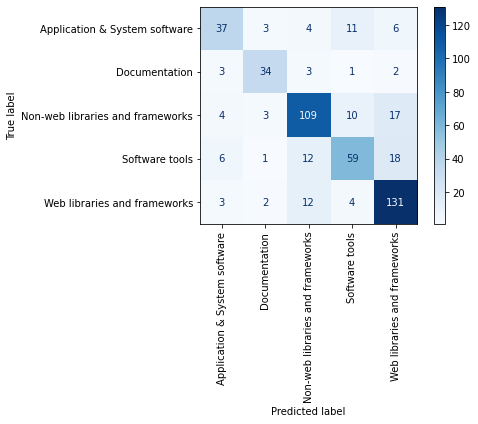

In [61]:
cnf_matrix = confusion_matrix(labels_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=target_names).plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

In [62]:
automl.best_config_per_estimator

{'lgbm': {'colsample_bytree': 0.9926206032810196,
  'learning_rate': 0.2541973743445076,
  'log_max_bin': 5,
  'min_child_samples': 20,
  'n_estimators': 1931,
  'num_leaves': 92,
  'reg_alpha': 0.039455650600180386,
  'reg_lambda': 117.54012507648228}}